In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/energy_time_60hr_most.root")
f.ls()

TFile**		./data/energy_time_60hr_most.root	
 TFile*		./data/energy_time_60hr_most.root	
  KEY: TCanvas	c1;1	c1


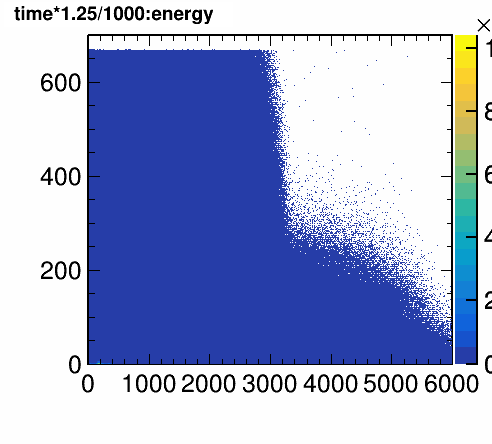

In [3]:
c1 = f.Get("c1")
c1.Draw()

In [4]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7ffffc8c3940>


In [5]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


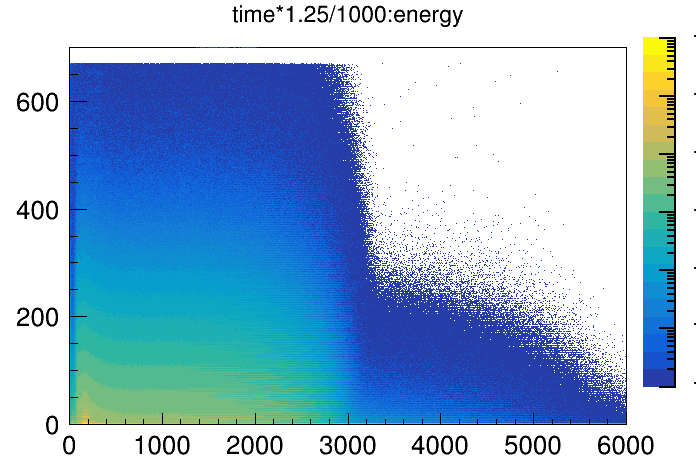

In [6]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

In [7]:
evt = h.Clone()

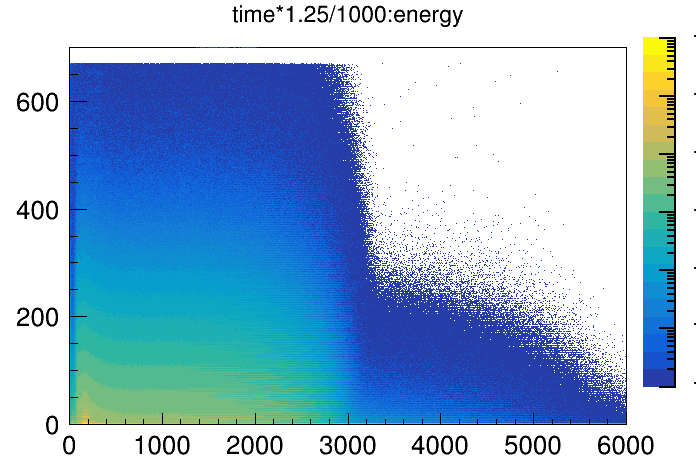

In [8]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

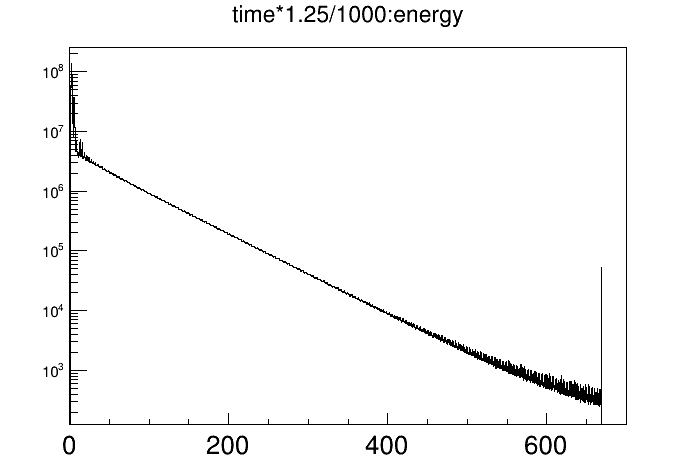

In [9]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

In [10]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > 30 and binCenter < 600):
        timeBinCenters.append(binCenter)

In [11]:
timeBinCenters[:10]

[30.010638297872337,
 30.159574468085104,
 30.30851063829787,
 30.457446808510635,
 30.606382978723403,
 30.755319148936167,
 30.904255319148934,
 31.0531914893617,
 31.202127659574465,
 31.351063829787233]

In [12]:
e1 = 500
e2 = 3100
t1 = 30
t2 = 600

Lets see what happens if we very this initial starting energy

In [13]:
e1s = [x for x in range(100,1800,100)]
print(e1s)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700]


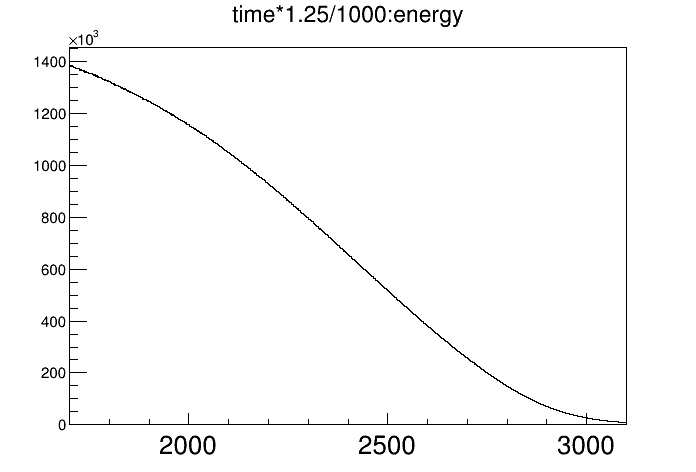

In [14]:
hs = []

for e1 in e1s:
    c2 = r.TCanvas()
    evt.GetXaxis().SetRangeUser(e1,e2)
    evt.GetYaxis().SetRangeUser(30,600)

    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
    hs.append(h.Clone("h"+str(e1)))
    #h.Scale(1/(h.GetEntries()))
    h.Draw()
    c2.Draw()

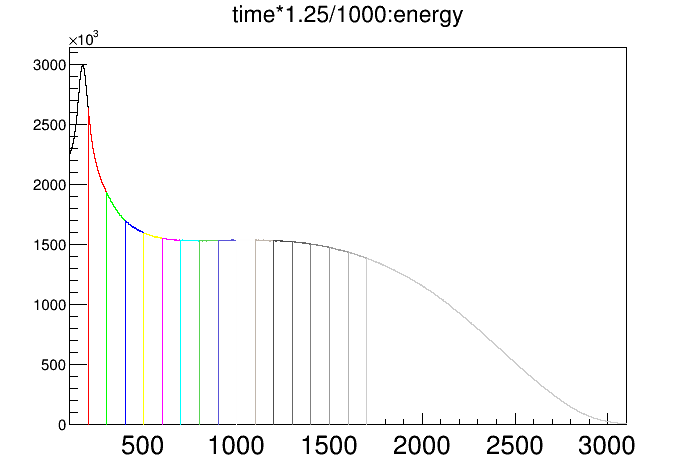

In [15]:
c = r.TCanvas()
for i, h in enumerate(hs):
    h.SetLineColor(i+1)
    if i < 1:
        h.Draw()
    else:
        h.Draw("SAME")
c.Draw()

In [16]:
hcums = []
for i,h in enumerate(hs):
    hcum = h.GetCumulative()
    hcums.append(hcum.Clone("hcum"+str(e1s[i])))

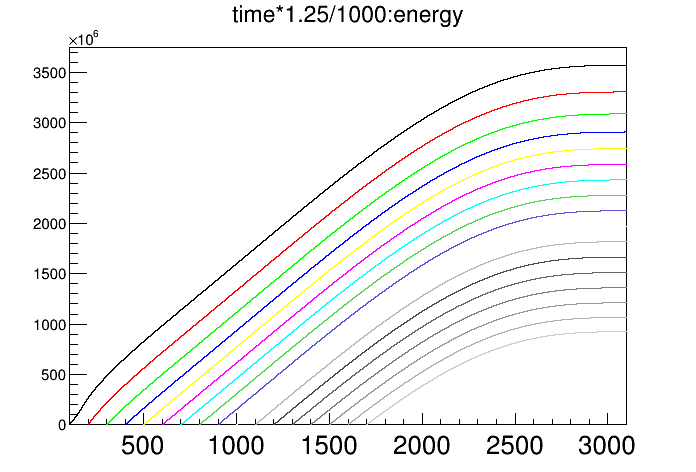

In [17]:
c = r.TCanvas()
for i, h in enumerate(hcums):
    h.SetLineColor(i+1)
    if i < 1:
        h.Draw()
    else:
        h.Draw("SAME")
c.Draw()

In [18]:
kss = []
for i, e1 in enumerate(e1s):
    print("Starting:",e1)
    ndivs = len(timeBinCenters)
    #print(ndivs)
    timeSlices = []
    timeSlicesCum = []
    times = []
    ks = []
    for div in range(ndivs):
        t1 = timeBinCenters[div] - timeBinWidth
        t2 = timeBinCenters[div] + timeBinWidth
        evt.GetYaxis().SetRangeUser(t1,t2)
        evt.GetXaxis().SetRangeUser(e1,e2)

        cuti = r.TCutG("cuti")
        cuti.SetPoint(0,e1,t1)
        cuti.SetPoint(1,e2,t1)
        cuti.SetPoint(2,e2,t2)
        cuti.SetPoint(3,e1,t2)
        cuti.SetPoint(4,e1,t1)

        htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
        htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))

        times.append(t1)
        
        hcumi = htemp.GetCumulative().Clone("hcum"+str(div+1))
        ksi = hcums[i].KolmogorovTest(hcumi,"M")
        
        '''
        c = r.TCanvas()
        c.Divide(2)
        c.cd(1)
        hcums[i].Draw("HIST")
        c.cd(2)
        hcumi.Draw("HIST")
        c.Draw()
        '''
        ks.append(ksi)
        
    kss.append(ks)

Starting: 100
Starting: 200
Starting: 300
Starting: 400
Starting: 500
Starting: 600
Starting: 700
Starting: 800
Starting: 900
Starting: 1000
Starting: 1100
Starting: 1200
Starting: 1300
Starting: 1400
Starting: 1500
Starting: 1600
Starting: 1700


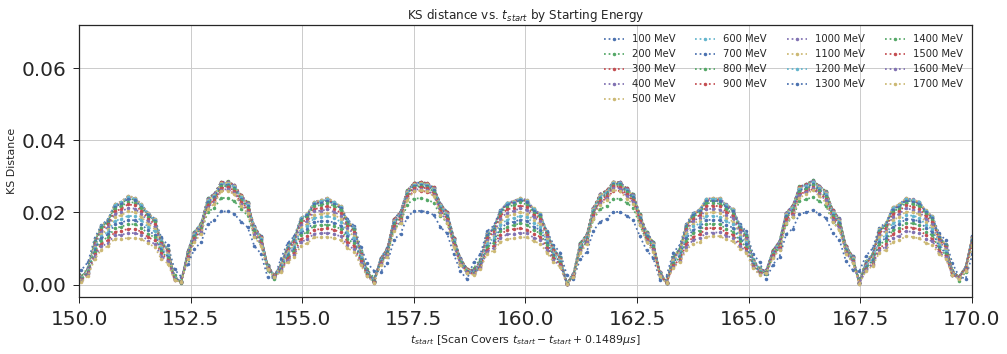

In [19]:
fig, ax = plt.subplots(figsize=(16,5))
for i, ks in enumerate(kss):
    plt.plot(times,ks,':.',label=str(e1s[i])+" MeV")
plt.title(r"KS distance vs. $t_{start}$ by Starting Energy")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(round(timeBinWidth,4))+r" \mu s$]")
plt.ylabel("KS Distance")
plt.xlim(150,170)
plt.grid()
plt.legend(ncol=4)
plt.show()

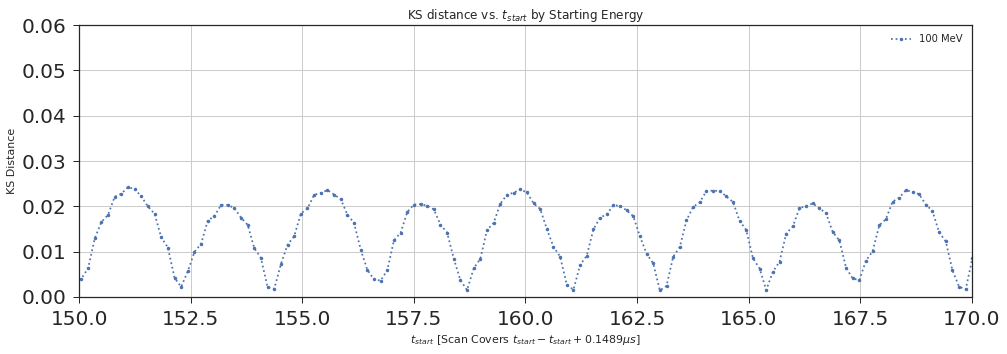

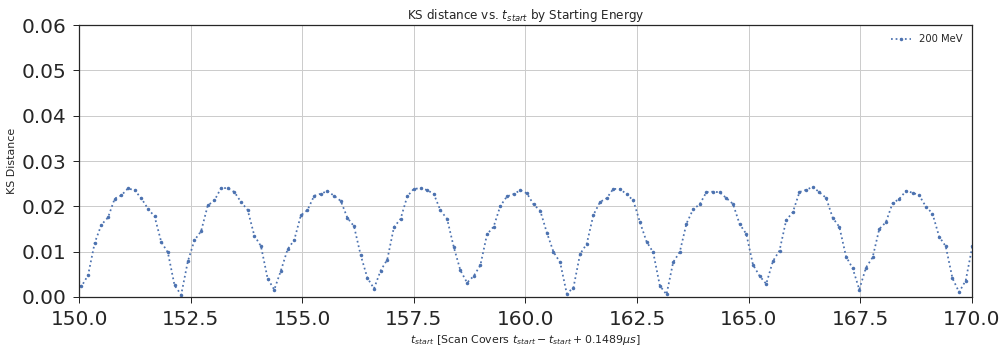

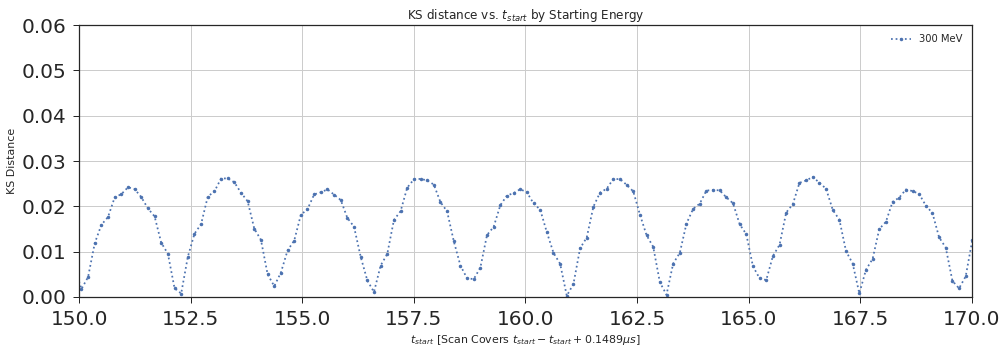

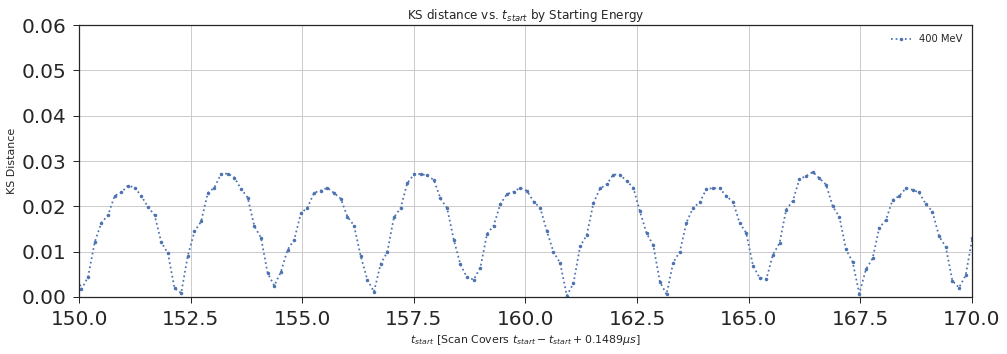

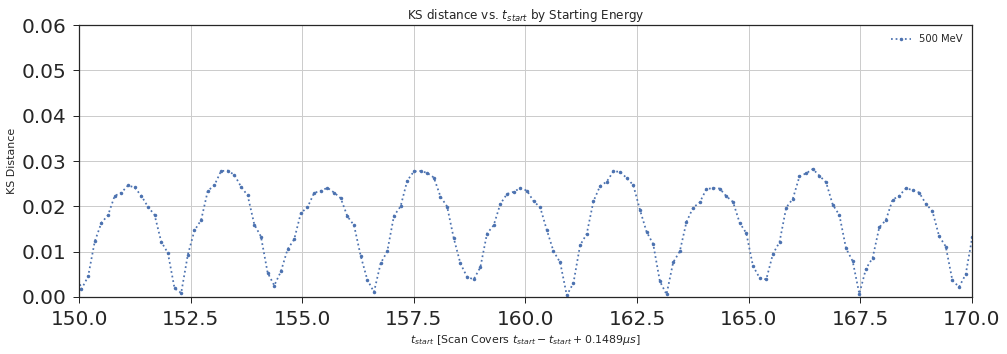

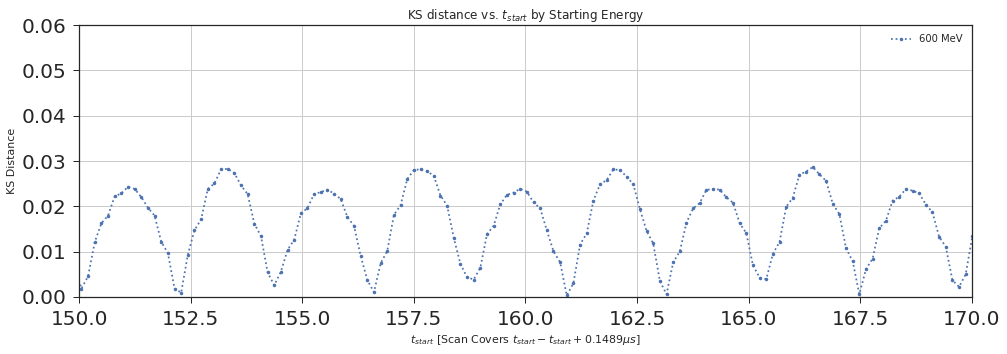

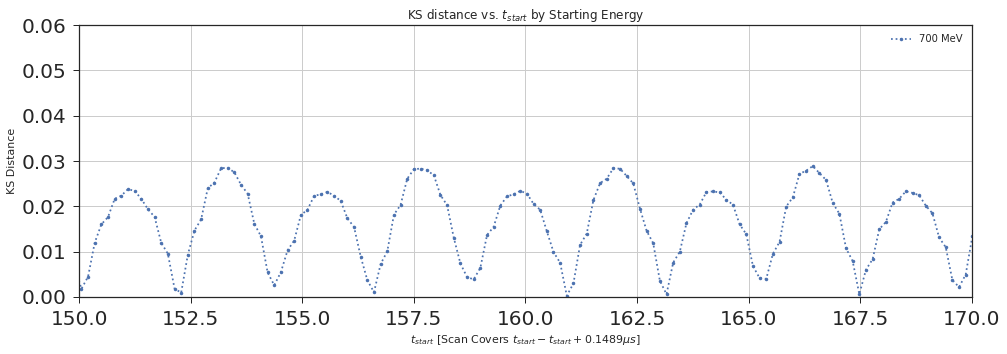

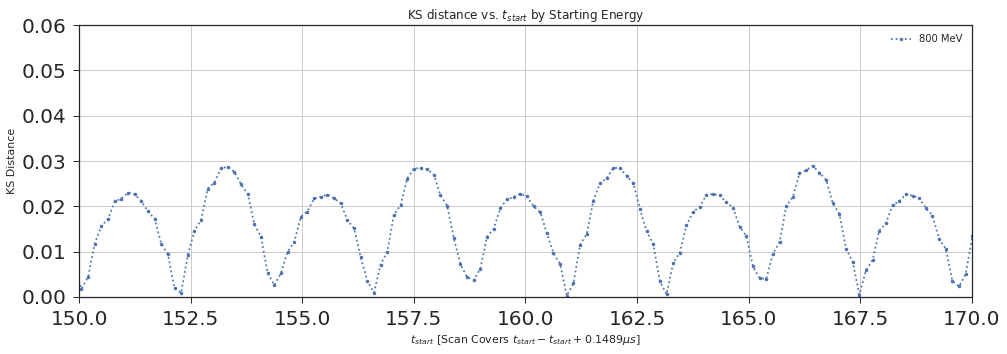

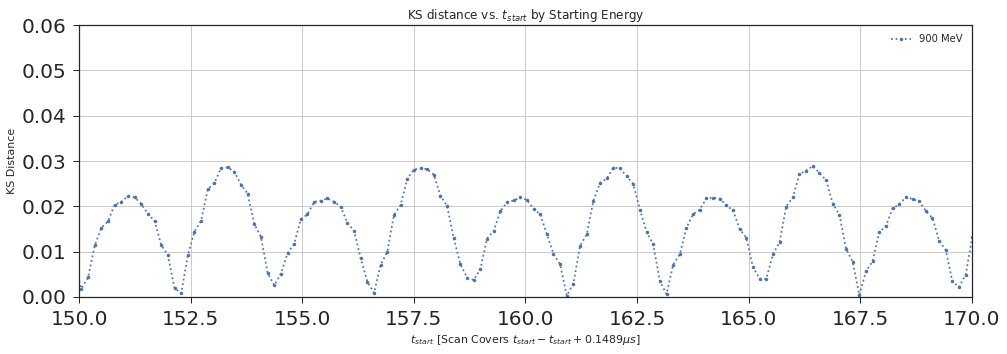

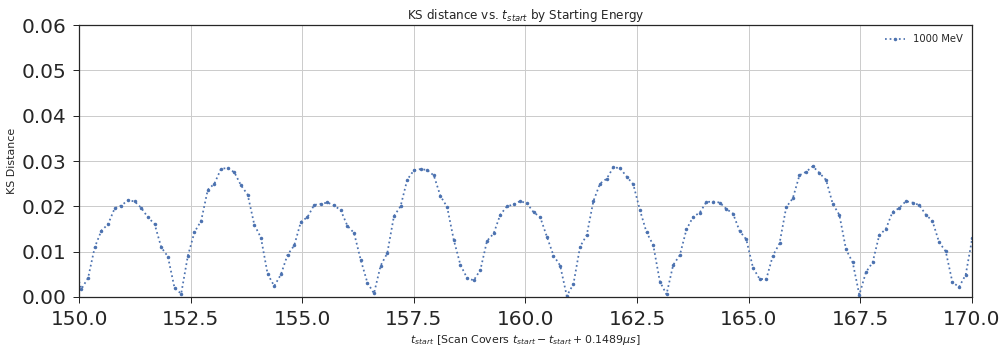

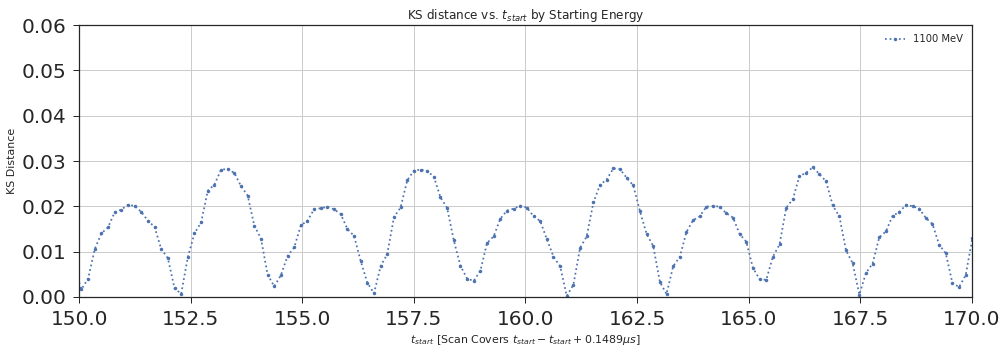

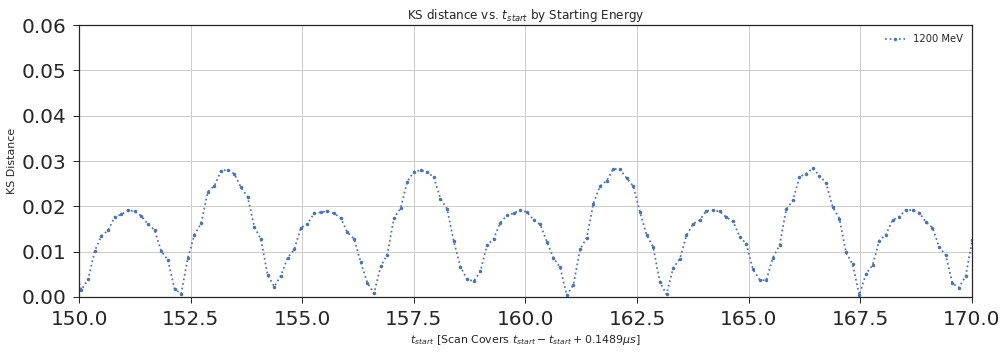

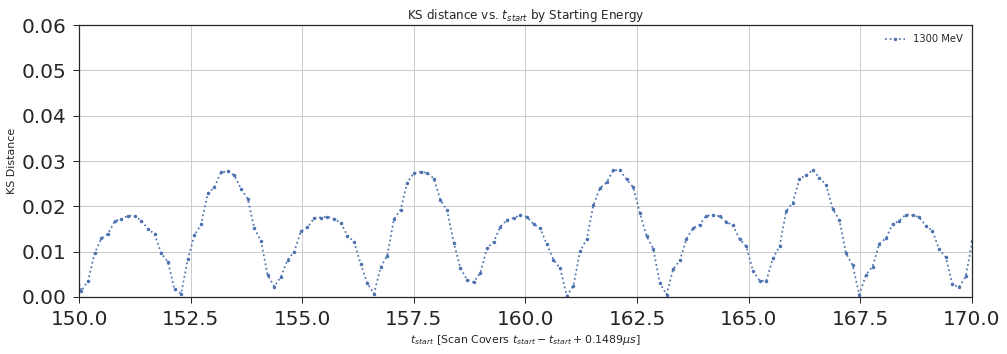

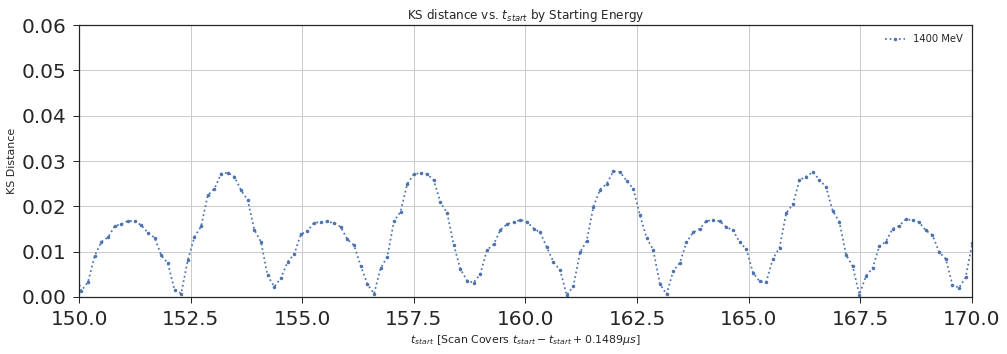

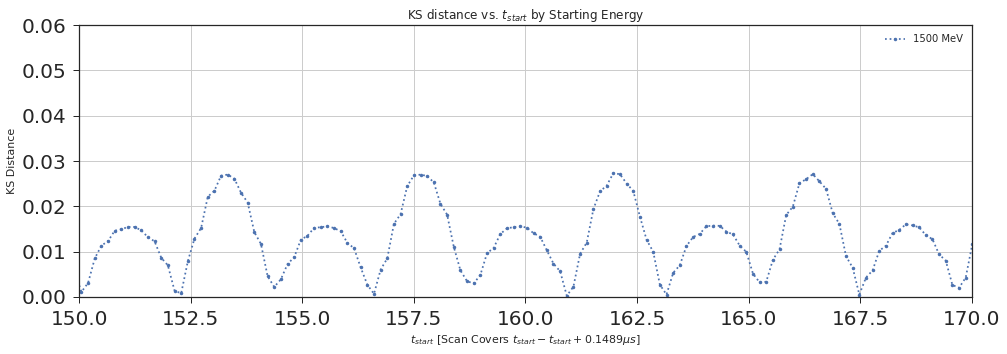

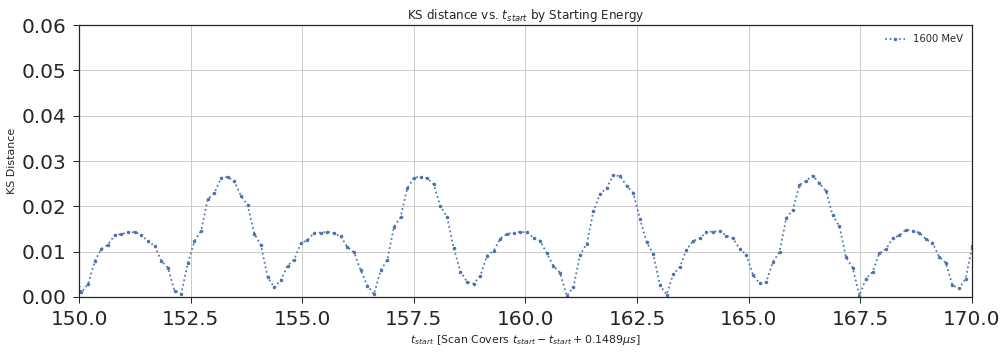

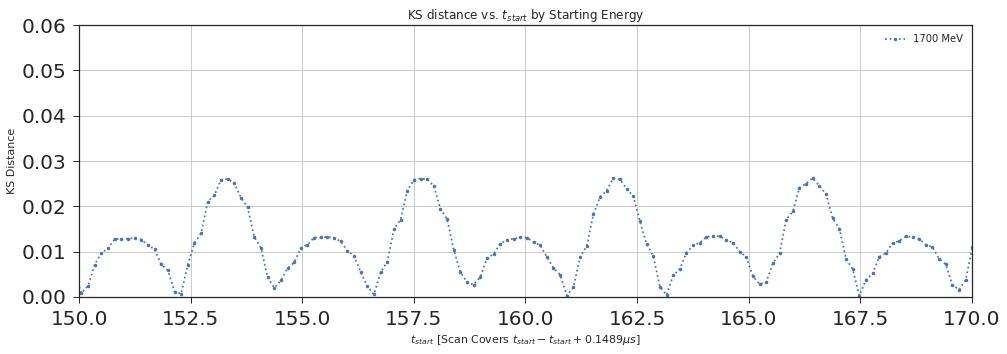

In [20]:
for i, ks in enumerate(kss):
    fig, ax = plt.subplots(figsize=(16,5))
    plt.plot(times,ks,':.',label=str(e1s[i])+" MeV")
    plt.title(r"KS distance vs. $t_{start}$ by Starting Energy")
    plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(round(timeBinWidth,4))+r" \mu s$]")
    plt.ylabel("KS Distance")
    plt.xlim(150,170)
    plt.ylim(0,0.06)
    plt.grid()
    plt.legend(ncol=4)
    plt.savefig("./images/ks_byStartEnergy_"+str(e1s[i]).zfill(5)+"_endPointEnergy_3100.png")
    plt.show()

---

### Now lets try to vary the energy endpoint

In [12]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7ffffc9e45c0>


In [13]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


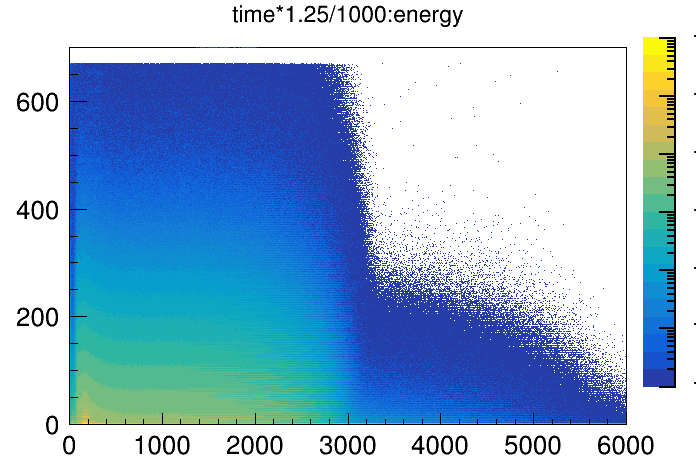

In [14]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

In [15]:
evt = h.Clone()

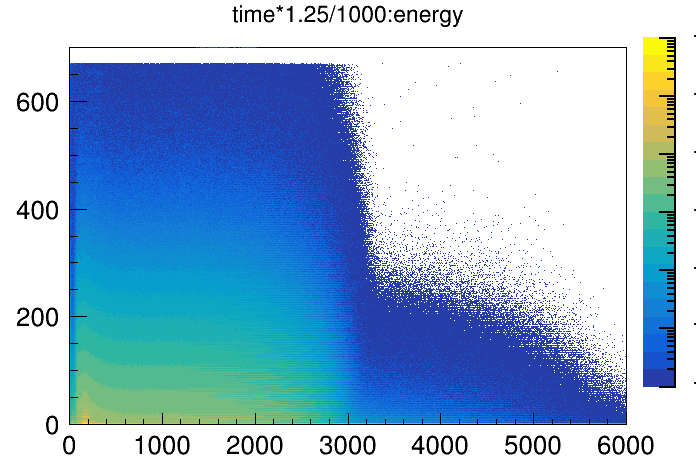

In [16]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

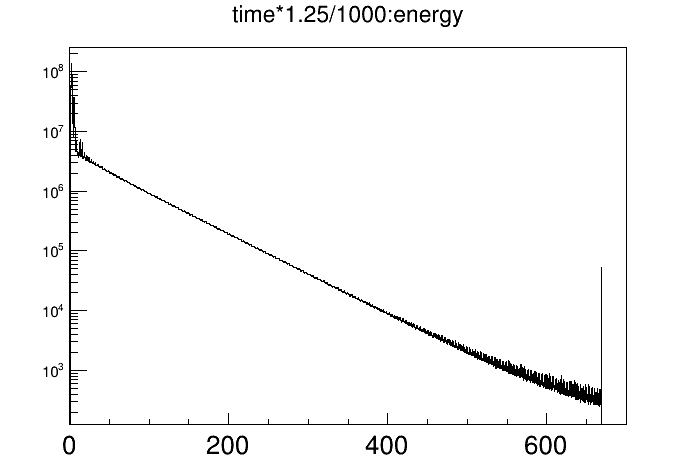

In [17]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

In [18]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > 30 and binCenter < 600):
        timeBinCenters.append(binCenter)

In [19]:
timeBinCenters[:10]

[30.010638297872337,
 30.159574468085104,
 30.30851063829787,
 30.457446808510635,
 30.606382978723403,
 30.755319148936167,
 30.904255319148934,
 31.0531914893617,
 31.202127659574465,
 31.351063829787233]

In [20]:
e1 = 1500
e2 = 3100
t1 = 30
t2 = 600

Lets see what happens if we very this initial starting energy

In [21]:
e2s = [x for x in range(1600,3100,100)]
print(e2s)

[1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]


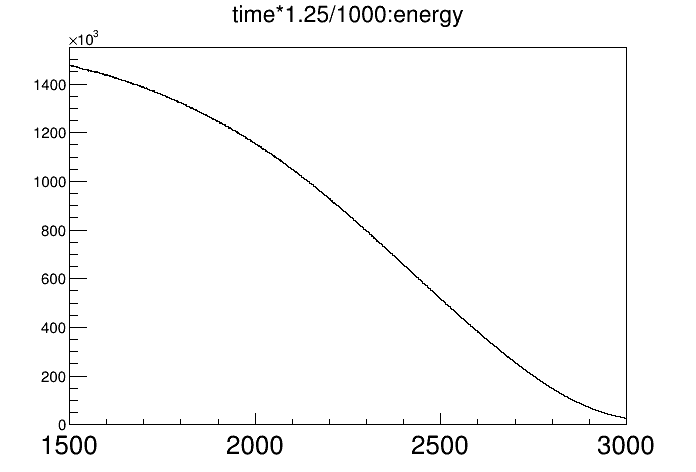

In [22]:
hs = []

for e2 in e2s:
    c2 = r.TCanvas()
    evt.GetXaxis().SetRangeUser(e1,e2)
    evt.GetYaxis().SetRangeUser(30,600)

    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
    hs.append(h.Clone("h"+str(e2)))
    #h.Scale(1/(h.GetEntries()))
    h.Draw()
    c2.Draw()

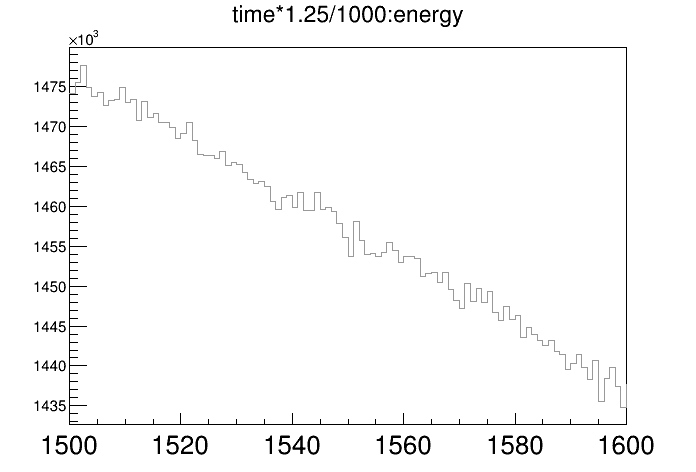

In [23]:
c = r.TCanvas()
for i, h in enumerate(hs):
    h.SetLineColor(i+1)
    if i < 1:
        h.Draw()
    else:
        h.Draw("SAME")
c.Draw()

In [24]:
hcums = []
for i,h in enumerate(hs):
    hcum = h.GetCumulative()
    hcums.append(hcum.Clone("hcum"+str(e2s[i])))

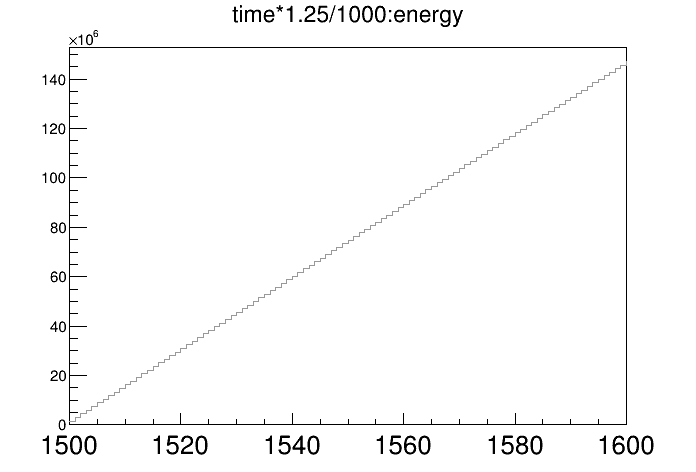

In [25]:
c = r.TCanvas()
for i, h in enumerate(hcums):
    h.SetLineColor(i+1)
    if i < 1:
        h.Draw()
    else:
        h.Draw("SAME")
c.Draw()

In [26]:
kss = []
for i, e2 in enumerate(e2s):
    print("Starting:",e2)
    ndivs = len(timeBinCenters)
    #print(ndivs)
    timeSlices = []
    timeSlicesCum = []
    times = []
    ks = []
    for div in range(ndivs):
        t1 = timeBinCenters[div] - timeBinWidth
        t2 = timeBinCenters[div] + timeBinWidth
        evt.GetYaxis().SetRangeUser(t1,t2)
        evt.GetXaxis().SetRangeUser(e1,e2)

        cuti = r.TCutG("cuti")
        cuti.SetPoint(0,e1,t1)
        cuti.SetPoint(1,e2,t1)
        cuti.SetPoint(2,e2,t2)
        cuti.SetPoint(3,e1,t2)
        cuti.SetPoint(4,e1,t1)

        htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
        htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))

        times.append(t1)
        
        hcumi = htemp.GetCumulative().Clone("hcum"+str(div+1))
        ksi = hcums[i].KolmogorovTest(hcumi,"M")
        
        '''
        c = r.TCanvas()
        c.Divide(2)
        c.cd(1)
        hcums[i].Draw("HIST")
        c.cd(2)
        hcumi.Draw("HIST")
        c.Draw()
        '''
        ks.append(ksi)
        
    kss.append(ks)

Starting: 1600
Starting: 1700
Starting: 1800
Starting: 1900
Starting: 2000
Starting: 2100
Starting: 2200
Starting: 2300
Starting: 2400
Starting: 2500
Starting: 2600
Starting: 2700
Starting: 2800
Starting: 2900
Starting: 3000


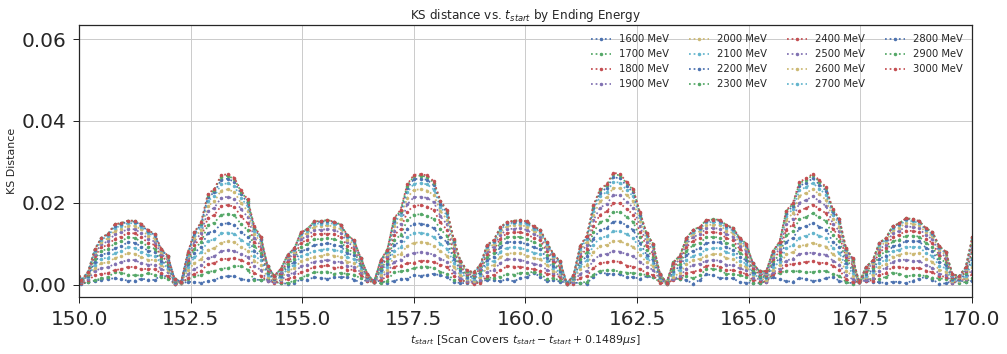

In [27]:
fig, ax = plt.subplots(figsize=(16,5))
for i, ks in enumerate(kss):
    plt.plot(times,ks,':.',label=str(e2s[i])+" MeV")
plt.title(r"KS distance vs. $t_{start}$ by Ending Energy")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(round(timeBinWidth,4))+r" \mu s$]")
plt.ylabel("KS Distance")
plt.xlim(150,170)
plt.grid()
plt.legend(ncol=4)
plt.show()

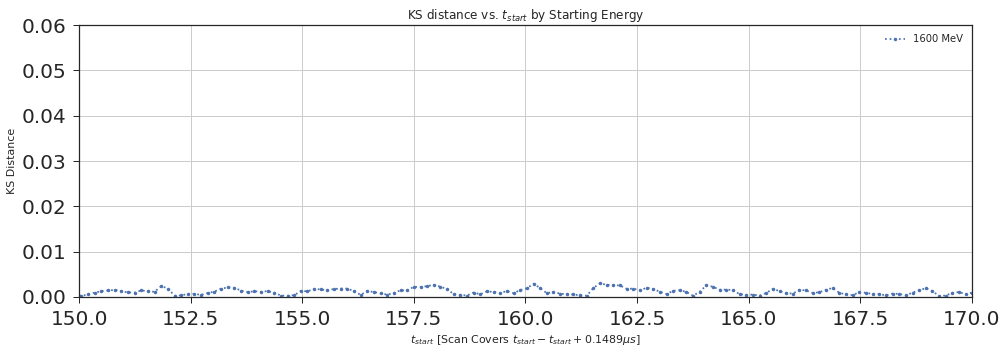

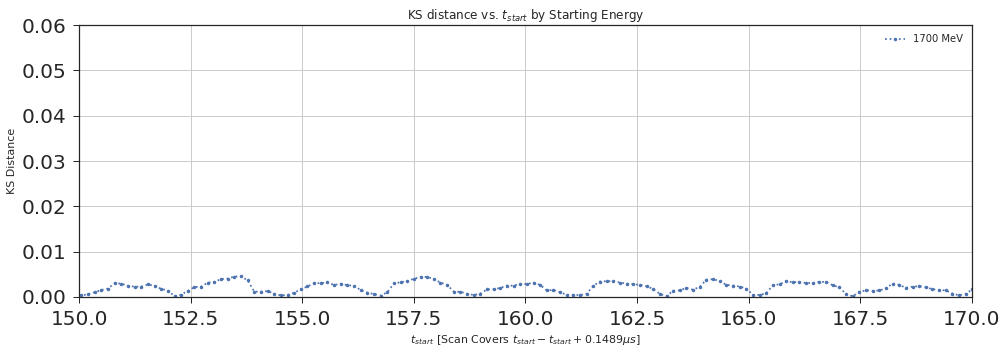

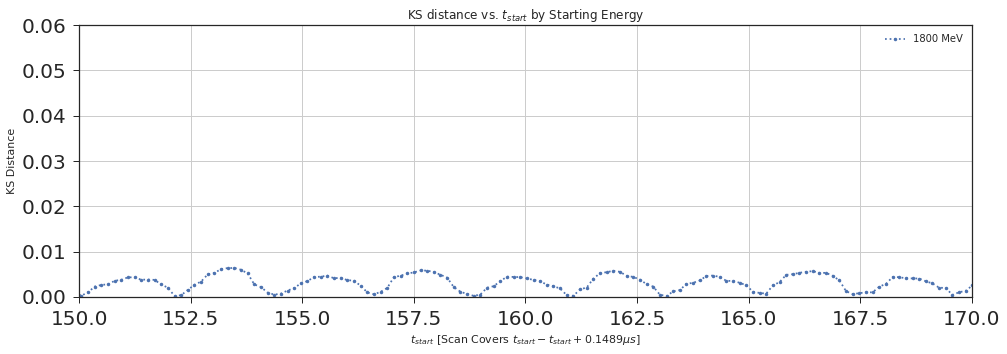

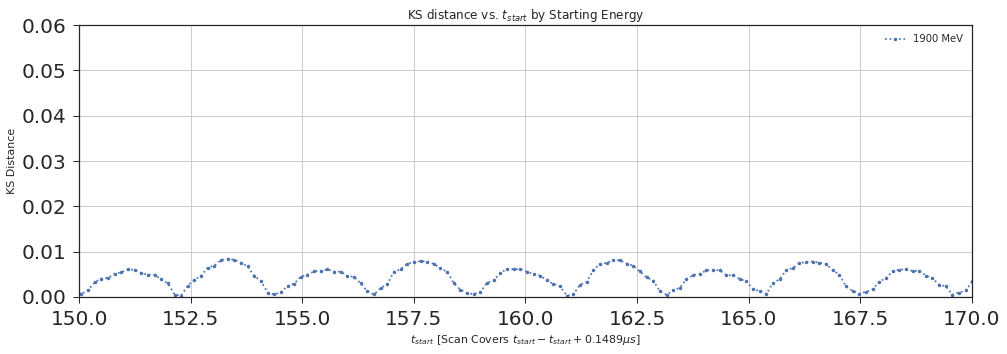

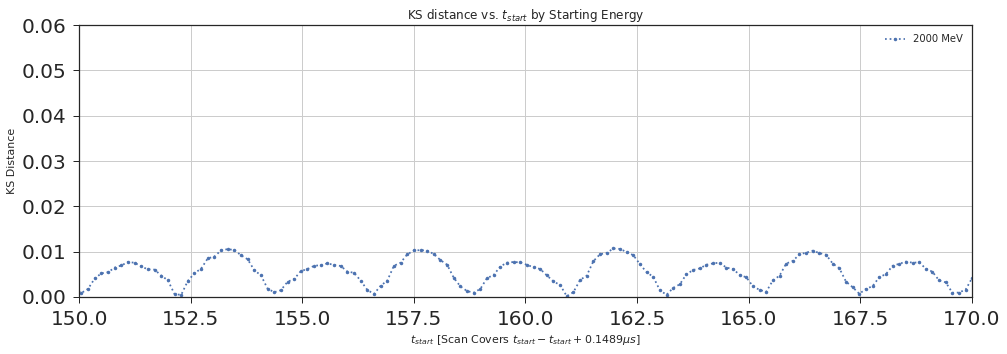

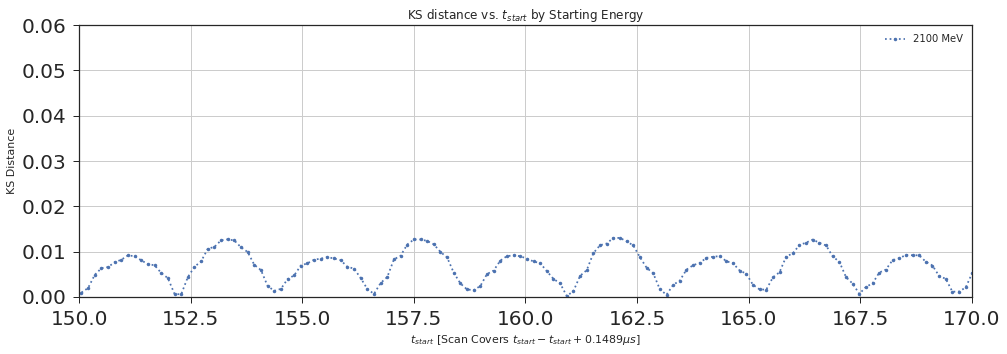

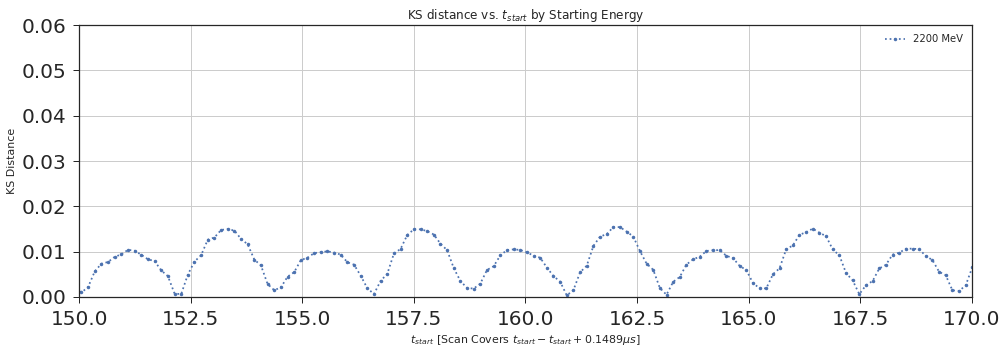

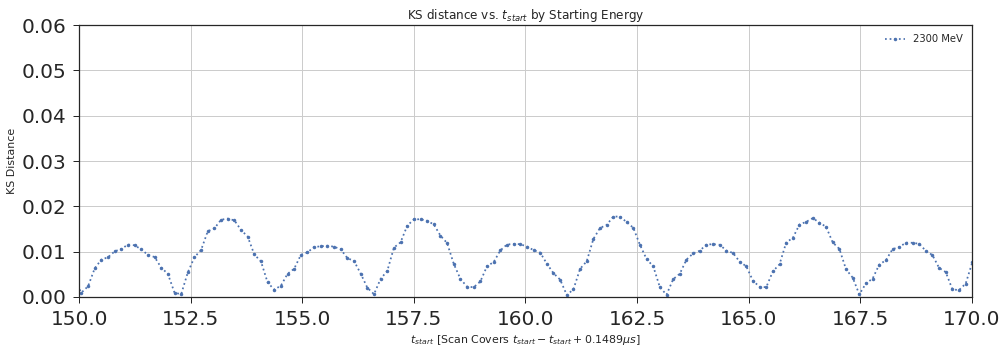

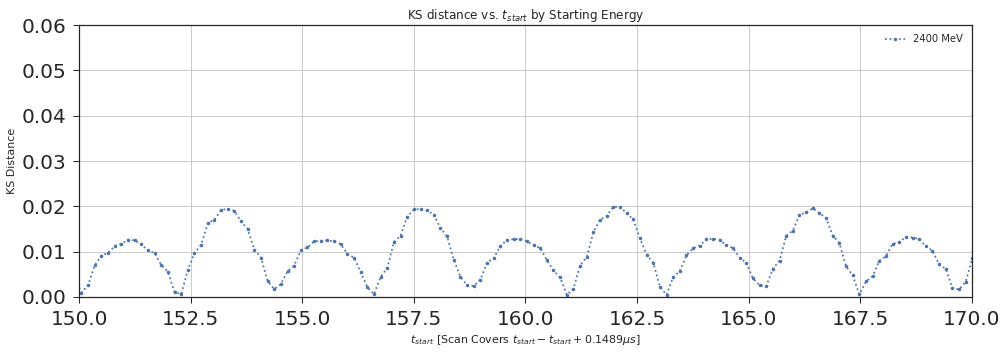

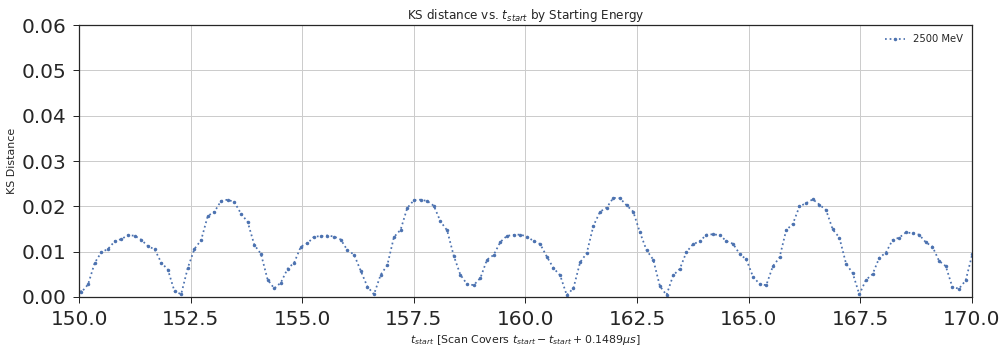

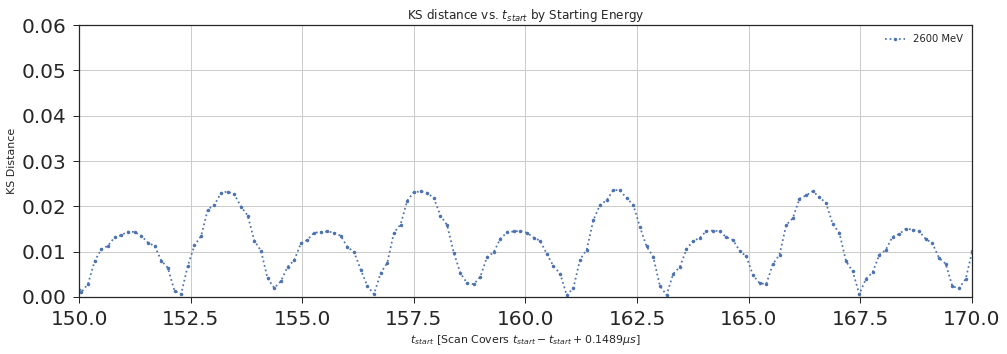

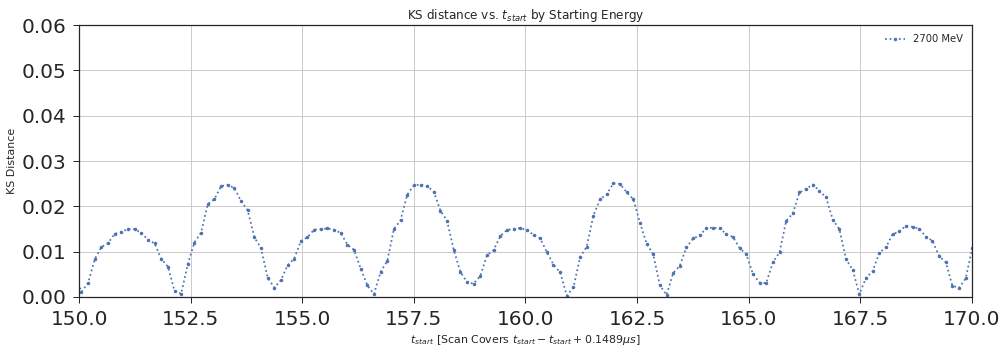

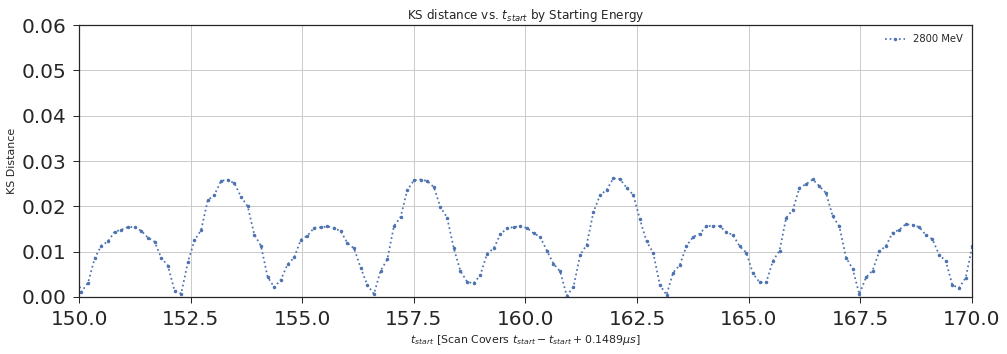

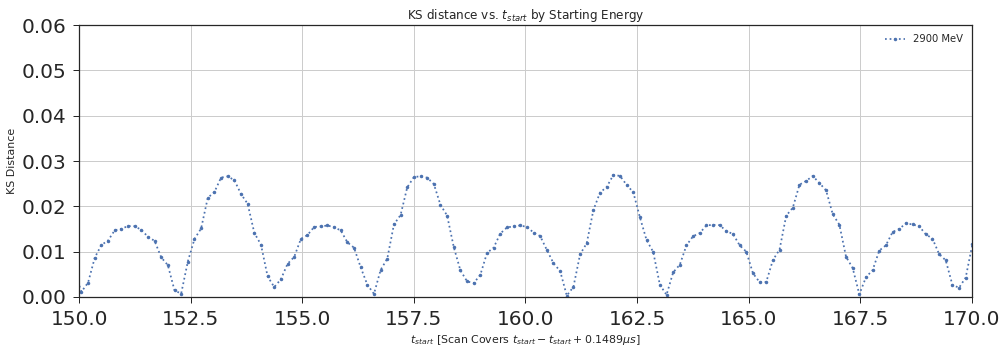

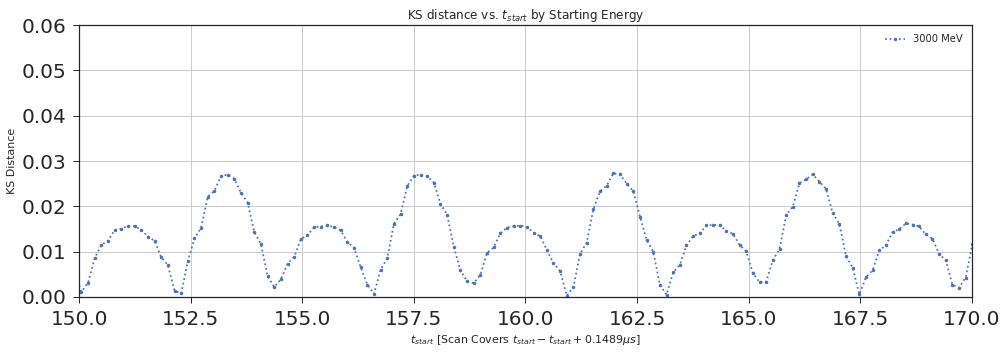

In [28]:
for i, ks in enumerate(kss):
    fig, ax = plt.subplots(figsize=(16,5))
    plt.plot(times,ks,':.',label=str(e2s[i])+" MeV")
    plt.title(r"KS distance vs. $t_{start}$ by Starting Energy")
    plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(round(timeBinWidth,4))+r" \mu s$]")
    plt.ylabel("KS Distance")
    plt.xlim(150,170)
    plt.ylim(0,0.06)
    plt.grid()
    plt.legend(ncol=4)
    plt.savefig("./images/ks_byStartEnergy_"+str(e1).zfill(5)+"_endPointEnergy_"+str(e2s[i]).zfill(5)+".png")
    plt.show()